# Extract DayNight Images

Create DayNight database for model training.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from PIL import Image

## Common functions

In [51]:
def img_size_count(img_folder, verbose=True):
    sizes = []
    img_folder = Path(img_folder)
    for img_path in tqdm(list(img_folder.glob('*.jpg'))):
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)
        except:
            if verbose:
                print(f'Error reading {img_path}')
    df_sizes = pd.DataFrame(sizes, columns=['width', 'height'])
    return df_sizes.value_counts().reset_index(name='count')

def img_size_count_plot(size_counts, figsize=(4, 3)):
    plt.figure(figsize=figsize)
    tick_label = [f"{w}x{h}" for w, h in size_counts[['width', 'height']].values]
    plt.bar(size_counts.index, size_counts['count'], tick_label=tick_label, alpha=0.7, color='blue')
    plt.xlabel('Image Size (width x height)')
    plt.ylabel('Count')
    plt.title('Number of Images by Size')
    plt.xticks()
    plt.tight_layout()
    sns.despine()

In [52]:
def resize_and_crop(image_path, output_path, target_size, size_filter=None):
    """
    Resize and crop an image to fit the target size.

    Parameters:
    - image_path: str, path to the input image file.
    - output_path: str, path to save the output image file.
    - target_size: tuple, (width, height) of the target size.
    - size_filter: list of tuples, [(width, height)] of input image sizes to resize.
      If None, resize all images. (Optional, default=None)
    """
    with Image.open(image_path) as img:
        original_width, original_height = img.size
        if size_filter is not None and (original_width, original_height) in size_filter:
            return None

        target_width, target_height = target_size

        original_aspect = original_width / original_height
        target_aspect = target_width / target_height

        if original_aspect > target_aspect:
            new_height = target_height
            new_width = int(new_height * original_aspect)
        else:
            new_width = target_width
            new_height = int(new_width / original_aspect)

        left = (new_width - target_width) / 2
        top = 0
        right = left + target_width
        bottom = top + target_height

        img = img.resize((new_width, new_height), Image.LANCZOS)
        img = img.crop((left, top, right, bottom))
        img.save(output_path)

In [53]:
def filter_dataframe(df, filter_dict):
    mask = pd.Series([True] * len(df))
    for col, values in filter_dict.items():
        mask &= df[col].isin(values)
    return df[mask]

def remove_all_files(folder_path):
    folder = Path(folder_path)
    if folder.exists() and folder.is_dir():
        for file in folder.iterdir():
            if file.is_file():
                file.unlink()
            elif file.is_dir():
                remove_all_files(file)

def transform_images(img_list, files_folder, output_folder, transformation, params_dict, delete_files=False):
    f = Path(output_folder)
    if not f.exists():
        f.mkdir(parents=True)
    elif delete_files:
        remove_all_files(f)

    src_folder = Path(files_folder)
    for img in tqdm(img_list, desc=f'Copying {f.name}'):
        src = src_folder / img
        dest = f / img
        transformation(src, dest, **params_dict)

## Search Parameters

In [54]:
labels_file_name = '../../no_sync/nexet/nexet/train.csv'

df_labels = pd.read_csv(labels_file_name)
df_labels.head(5)

,image_filename,lighting,city
0,frame_20f328fa-2459-46d0-97a5-5ae2d6103cb0_000...,Twilight,NYC
1,frame_927bde20-f97f-48c2-af30-f9127b6b32ce_000...,Day,NYC
2,frame_67012509-f3bd-4175-a9d2-565a7b6bb3c7_000...,Day,NYC
3,frame_bd043377-6fb8-407a-95e5-7deb1fbab13a_000...,Day,NYC
4,frame_4da1583b-58d0-4893-8149-54541191031d_000...,Day,NYC


In [55]:
img_folder = '../../no_sync/nexet/nexet/nexet_2017_1/'

img_folder = Path(img_folder)
file_count = len([f for f in img_folder.iterdir() if f.is_file()])
print(f'There are {file_count} files in the folder.')

There are 50001 files in the folder.


100%|██████████| 50000/50000 [00:12<00:00, 4115.39it/s]


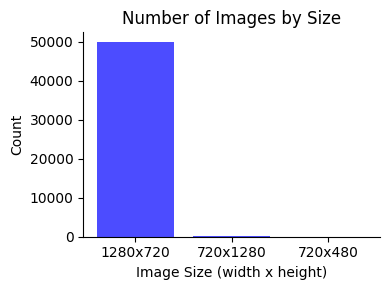

In [56]:
df_count = img_size_count(img_folder, verbose=False)
img_size_count_plot(df_count)

In [57]:
def search_and_transform_images(search_params):
    for f_name, filter_df in search_params['folders'].items():
        img_list = filter_dataframe(search_params['df_labels'], filter_df)['image_filename']
        transform_images(
            img_list=img_list,
            files_folder=search_params['src_folder'],
            output_folder=Path(search_params['dest_folder']) / f_name,
            transformation=search_params['transformation']['function'],
            params_dict=search_params['transformation']['params'],
            delete_files=False)

search_params = {
    'df_labels': df_labels,
    'src_folder': img_folder,
    'dest_folder': '../data/external/nexet/',
    'folders': {
        'input_A': {'lighting':['Day'], 'city':['NYC']},
        'input_B': {'lighting':['Night'], 'city':['NYC']},
    },
    'transformation':{
        'function': resize_and_crop,
        'params':{'target_size':(256,144), 'size_filter':(1280, 720)},
    },
}

search_and_transform_images(search_params)

Copying input_B: 100%|██████████| 4449/4449 [00:49<00:00, 90.59it/s]
